## Import icbhi-preprocessing-v3 data before running

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Not immediately usable with this dataset as files contain 24-bit data
from scipy.io import wavfile
from scipy.io.wavfile import read, write

import IPython.display as ipd
from IPython.display import Audio
from numpy.fft import fft, ifft

import librosa as lr
import librosa.display

import os
import pickle
from glob import glob

import seaborn as sns

from scipy import signal as sig
from scipy.signal import butter, lfilter, sosfilt
from tqdm import tqdm
import pywt
import random
import skimage.data
from skimage.restoration import denoise_wavelet
from pywt import swt
import time as tm
import collections

# if ('pydub' in globals()) == False:
#   !pip install pydub
# from pydub import AudioSegment
# from pydub.utils import make_chunks


# LT-06-24: import io to save intermediate outputs; use "as" to shorten module.function name as "spio"
import scipy.io as spio


# LT-06-24: install modules if not found 
# if ( 'umap' in globals() ) == False: 
#   !pip install umap-learn

import umap.umap_ as umap

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

print('Importing done')

Importing done


# Preprocessed Data

In [2]:
prepro_slices = np.load("../input/icbhi-preprocessing-v3/prepro_slices.npy")

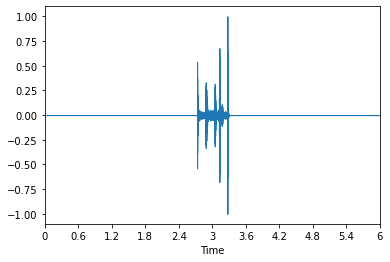

In [3]:
lr.display.waveplot(prepro_slices[0], sr=8000);
plt.xlim([0,6]);

# Extraction
### Evaluation of features for classification of wheezes and normal respiratory sounds (Pramono et al., 2019)

In [4]:
def extract(signal, sr=8000):
    """
    signal: slice that has already undergone preprocessing
    sr: sampling rate of slice
    """
    # Spectrograms
    stft = lr.stft(signal)
    spec = lr.amplitude_to_db(abs(stft))
    
#     # Spectral centroids
#     cent = lr.feature.spectral_centroid(signal, sr, n_fft=512, hop_length=256)[0]
    
    # Mel-cepstral frequency coefficients
    mfcc = lr.feature.mfcc(signal, sr, n_mfcc=13)
    
    # Wavelet transform using Baubechies with 4 vanishing moments
    modwt = np.array(pywt.dwt(signal, 'db4', mode='zero'))
#     # Absolute mean
#     abm = abs(np.nanmean(modwt))
#     # Standard deviation
#     sd = np.nanstd(modwt)
    # Zero crossing rate
    wt_zcr = len(np.nonzero(np.diff(np.array(modwt) > 0))[0])
    
    return spec, mfcc, wt_zcr

In [5]:
def save_extraction(preprocessed_slices):
    for i, signal in enumerate(preprocessed_slices):
        # Extract
        spec, mfcc, wt_zcr = extract(signal)
        
        # Reshape
        a,b = spec.shape
        c,d = mfcc.shape
        spec = spec.reshape((a*b))
        mfcc = mfcc.reshape((c*d))
        features = np.hstack((spec, mfcc, wt_zcr))
        
        # Naming
        filename = str(i) + '_features.npy'
        
        np.save(filename, features)
        
    return print('done')

In [6]:
# def save_specific_extraction( i, demo=0 ):
#     signal  = prepro_slices[i, ]
#     # Extract
#     spec, mfcc, wt_zcr = extract(signal )

#     # Reshape
#     a,b = spec.shape
#     c,d = mfcc.shape
#     spec = spec.reshape((a*b))
#     mfcc = mfcc.reshape((c*d))
#     features = np.hstack((spec, mfcc, wt_zcr))

#     # Naming
#     filename = str(i) + '_features' + '.npy'

    
#     np.save(filename, features)       
#     z=[]
#     if demo:
#         # l1,l2,l3 = spec.shape, mfcc.shape, wt_zcr.shape
#         z=[len(spec),len(mfcc),1]
#     return signal, z
# signal, z = save_specific_extraction( 121, 1 )
# print(z)    

In [7]:
def load_all_files(directory):
    files = list(map(lambda p: os.path.splitext(os.path.basename(p))[0],
                    glob(os.path.join(directory, '*.npy'))))
    
    samples = {}
    for filename in files:
        samples[filename] = np.load(os.path.join(directory, filename + '.npy'))
    return samples    

In [8]:
# check file count 
# from glob import glob
# f=sorted( glob('../input/icbhi-extraction-v2/*npy') )
# print( len(f), len(class_list) )

    

In [9]:
# directory = '../input/icbhi-extraction-v2/' 
# nsamples = len(class_list)
# features = np.zeros( (1000, 536647) )
# subset = np.zeros( 1000 ).astype(int)

# inc=-1
# for d in range( 0, nsamples, nsamples//100 ):
#     try: # quick hack to read some        
#         inc+=1 
#         subset[inc] = class_list[d] 
#         print(inc, subset[inc], end=', ' )
#         features[inc,:] = np.load(directory+ '%d_features.npy' % d )
#     except:
#         break


In [10]:
# plt.plot(subset, 'r')

In [11]:
# plt.plot( features[0,529925: ] );

In [12]:
# plt.plot( features[21,529925: ] );


In [13]:
if os.path.exists('../input/icbhi-extraction-v3/0_features.npy'):
    print('loaded')
    features = load_all_files('../input/icbhi-extraction-v3')
else:
    print('saved')
    save_extraction(prepro_slices)

saved
done


In [14]:
# n = len(class_list)

In [15]:
# ordered_classes = np.zeros(n).astype(int)
# for i, key in enumerate(features.keys()):
#     index = int(key.split('_')[0])
#     ordered_classes[i] = class_list[index]
# ordered_classes

In [16]:
# features = list(features.values())